In [4]:
import lmfit
import scipy.stats as ss

# import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.formula.api import ols, rlm
import sys
sys.path.append('../')

from Linearity import Neuron
from matplotlib import  rc
rc('text', usetex=False)

import pickle
import matplotlib.pyplot as plt
plt.style.use('neuron')
import numpy as np
import scipy.optimize as so
import glob

In [5]:
def simpleaxis(axes, every=False, outward=False):
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    for ax in axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if (outward):
            ax.spines['bottom'].set_position(('outward', 10))
            ax.spines['left'].set_position(('outward', 10))
        else:
            pass
#             ax.spines['bottom'].set_position(('outward', 10))
#             ax.spines['left'].set_position(('outward', 10))

        if every:
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_title('')

In [28]:
def linearModel(x, beta=100):
    # Linear model
    return (x*(1-beta))

def DN_model(x, gamma=1):
    # Divisive normalization modelg
    #return x - a*(x**2)/(b+x)
    #return ((x**2)*(1-beta) + (gamma*x))/(x+gamma)
    return (gamma*x)/(x+gamma)

In [89]:
def expDecay(x,a=0.,b=-1.):
    return a + np.exp(-b*x)

In [95]:
def one_by_x(x,k = 1.0, c=10.):
    return c + (k/x)

In [29]:
def line(x,m=1,c=0):
    return m*x + c

In [9]:
def getRsquared(xdata, ydata, popt, f):
    residuals = ydata- f(xdata, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

In [10]:
def convertInfToNan(nparr):
    for i, x in enumerate(nparr):
        if not np.isfinite(x):
            nparr[i] = np.nan
    return nparr

In [11]:
def getSDNPlotVals(filename):
    with open(filename) as f:  # Python 3: open(..., 'rb')
        sdn_x, sdn_y, sdn_y2, EI_ratio_arr, EI_pair, EI_onset = pickle.load(f)

    sdn_x = np.array(sdn_x)
    sdn_y = np.array(sdn_y)
    sdn_y2 = np.array(sdn_y2)
    IE_ratio_arr = np.array(EI_ratio_arr)

    repeats = 6
    sdn_x, sdn_y, sdn_y2, IE_ratio_arr = convertInfToNan(sdn_x), convertInfToNan(sdn_y), convertInfToNan(sdn_y2), convertInfToNan(IE_ratio_arr)

    sdn_x = sdn_x.reshape(len(sdn_x)/repeats, repeats)
    sdn_y = sdn_y.reshape(len(sdn_y)/repeats, repeats)
    sdn_y2 = sdn_y2.reshape(len(sdn_y2)/repeats, repeats)
    IE_ratio_arr = IE_ratio_arr.reshape(len(IE_ratio_arr)/repeats, repeats)

    sdn_x, sdn_y, sdn_y2, IE_ratio_arr = np.nanmean(sdn_x, axis=1), np.nanmean(sdn_y, axis=1), np.nanmean(sdn_y2, axis=1), np.nanmean(IE_ratio_arr, axis=1)
    arr_x, arr_y, arr_y2, arr_c = [], [], [], []
    for (x,y,z,c) in zip(sdn_x, sdn_y, sdn_y2, IE_ratio_arr):
        if not any(np.isnan([x,y,z])):
            arr_x.append(x)
            arr_y.append(y)
            arr_y2.append(z)
            arr_c.append(c)
    sdn_x, sdn_y, sdn_y2, IE_ratio_arr = np.array(arr_x), np.array(arr_y), np.array(arr_y2), np.array(arr_c)
    sorting = np.argsort(sdn_x)
    sdn_x, sdn_y, sdn_y2, IE_ratio_arr = sdn_x[sorting], sdn_y[sorting], sdn_y2[sorting], IE_ratio_arr[sorting]

    return sdn_x, sdn_y, sdn_y2, IE_ratio_arr

In [12]:
def scatterPlot(sdn_x, sdn_y, sdn_y2, IE_ratio_arr):
    fig, ax = plt.subplots()
    ax.scatter(sdn_x, sdn_y, marker='.', c='k')
    ax.scatter(sdn_x, sdn_y2, marker='.', c='r')#facecolors='none', edgecolors='0.5')
    # ax[0].plot(sdn_x, sdn_y_pred, '--', label="Fitted Curve")
    # ax[1].plot(sdn_x, sdn_y2_pred, '--', label="Fitted Curve")

    ax.set_xlabel("Conductance (nS)")
#     ax[1].set_xlabel("Conductance (nS)")
    ax.set_ylabel("Spike times (ms)")

    # ax[0].set_xlim(xmin=0.)
    # ax[0].set_ylim(ymin=10.)

    simpleaxis(ax)
    fig.set_figwidth(2)
    fig.set_figheight(2)
    return fig, ax

    # popt, pcov = so.curve_fit(expDecay, sdn_x, sdn_y)
    # sdn_y_pred = expDecay(sdn_x, *popt)

    # popt, pcov = so.curve_fit(expDecay, sdn_x, sdn_y2)
    # sdn_y2_pred = expDecay(sdn_x, *popt)


In [9]:
sdn_xl, sdn_yl, sdn_y2l = sdn_x, np.log(sdn_y), np.log(sdn_y2)

popt, pcov = so.curve_fit(line, sdn_xl, sdn_yl)
sdn_yl_pred = line(sdn_xl, *popt)
print(popt, getRsquared(sdn_xl, sdn_yl, popt, line))

popt, pcov = so.curve_fit(line, sdn_xl, sdn_y2l)
sdn_y2l_pred = line(sdn_xl, *popt)
print(popt, getRsquared(sdn_xl, sdn_y2l, popt, line))

sorting = np.argsort(sdn_xl)

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(sdn_xl, sdn_yl, marker='o', c='k')
ax[0].scatter(sdn_xl, sdn_y2l, marker='o', c='r')#facecolors='none', edgecolors='0.5')
ax[0].plot(sdn_xl[sorting], sdn_yl_pred[sorting], 'k-', label="Fitted Curve")
ax[0].plot(sdn_xl[sorting], sdn_y2l_pred[sorting], 'g-', label="Fitted Curve")
plt.show()

NameError: name 'sdn_x' is not defined

In [13]:
def convertInfToNan(array):
    return np.array([np.nan if isinf else array[k] for (k, isinf) in enumerate(np.isinf(array))])

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170531_c2_EI_0.045_spikes.pkl
Parameters([('c', <Parameter 'c', 10.0, bounds=[-inf:inf]>), ('k', <Parameter 'k', 1.0, bounds=[-inf:inf]>)])
[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 40
    # data points      = 80
    # variables        = 2
    chi-square         = 1024.582
    reduced chi-square = 13.136
    Akaike info crit   = 208.001
    Bayesian info crit = 212.765
[[Variables]]
    c:   9.65502273 (init= 10)
    k:   1.37064029 (init= 1)

[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 89
    # variables        = 2
    chi-square         = 460.991
    reduced chi-square = 5.299
    Akaike info crit   = 150.382
    Bayesian info crit = 155.359
[[Variables]]
    c:   10.9151667 (init= 10)
    k:   1.06899133 (init= 1)



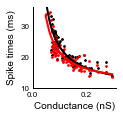

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170530_c1_EI_0.045_spikes.pkl
Parameters([('c', <Parameter 'c', 10.0, bounds=[-inf:inf]>), ('k', <Parameter 'k', 1.0, bounds=[-inf:inf]>)])
[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 34
    # data points      = 130
    # variables        = 2
    chi-square         = 583.294
    reduced chi-square = 4.557
    Akaike info crit   = 199.150
    Bayesian info crit = 204.886
[[Variables]]
    c:   12.1225155 (init= 10)
    k:   1.38943008 (init= 1)

[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 147
    # variables        = 2
    chi-square         = 298.858
    reduced chi-square = 2.061
    Akaike info crit   = 108.302
    Bayesian info crit = 114.283
[[Variables]]
    c:   10.4207021 (init= 10)
    k:   0.96253815 (init= 1)



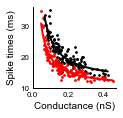

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170720_c4_EI_0.045_spikes.pkl
Parameters([('c', <Parameter 'c', 10.0, bounds=[-inf:inf]>), ('k', <Parameter 'k', 1.0, bounds=[-inf:inf]>)])
[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 37
    # variables        = 2
    chi-square         = 79.020
    reduced chi-square = 2.258
    Akaike info crit   = 32.075
    Bayesian info crit = 35.297
[[Variables]]
    c:   11.1546407 (init= 10)
    k:   1.10475638 (init= 1)

[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 40
    # variables        = 2
    chi-square         = 65.781
    reduced chi-square = 1.731
    Akaike info crit   = 23.898
    Bayesian info crit = 27.276
[[Variables]]
    c:   10.8590043 (init= 10)
    k:   0.95452018 (init= 1)



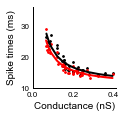

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170530_c2_EI_0.045_spikes.pkl
Parameters([('c', <Parameter 'c', 10.0, bounds=[-inf:inf]>), ('k', <Parameter 'k', 1.0, bounds=[-inf:inf]>)])
[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 34
    # data points      = 98
    # variables        = 2
    chi-square         = 709.329
    reduced chi-square = 7.389
    Akaike info crit   = 197.977
    Bayesian info crit = 203.146
[[Variables]]
    c:   10.4320241 (init= 10)
    k:   1.11731456 (init= 1)

[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 40
    # data points      = 112
    # variables        = 2
    chi-square         = 283.493
    reduced chi-square = 2.577
    Akaike info crit   = 108.013
    Bayesian info crit = 113.450
[[Variables]]
    c:   10.2062172 (init= 10)
    k:   0.90765703 (init= 1)



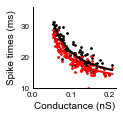

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170531_c1_EI_0.045_spikes.pkl
Parameters([('c', <Parameter 'c', 10.0, bounds=[-inf:inf]>), ('k', <Parameter 'k', 1.0, bounds=[-inf:inf]>)])
[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 145
    # variables        = 2
    chi-square         = 5344.835
    reduced chi-square = 37.376
    Akaike info crit   = 527.037
    Bayesian info crit = 532.991
[[Variables]]
    c:   13.0871210 (init= 10)
    k:   1.86836568 (init= 1)

[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 34
    # data points      = 164
    # variables        = 2
    chi-square         = 3278.236
    reduced chi-square = 20.236
    Akaike info crit   = 495.212
    Bayesian info crit = 501.412
[[Variables]]
    c:   11.6919865 (init= 10)
    k:   1.68921883 (init= 1)



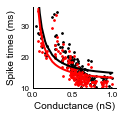

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170524_c1_EI_0.045_spikes.pkl
Parameters([('c', <Parameter 'c', 10.0, bounds=[-inf:inf]>), ('k', <Parameter 'k', 1.0, bounds=[-inf:inf]>)])
[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 56
    # variables        = 2
    chi-square         = 721.313
    reduced chi-square = 13.358
    Akaike info crit   = 147.120
    Bayesian info crit = 151.171
[[Variables]]
    c:   16.5968374 (init= 10)
    k:   0.85262442 (init= 1)

[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 79
    # variables        = 2
    chi-square         = 970.824
    reduced chi-square = 12.608
    Akaike info crit   = 202.187
    Bayesian info crit = 206.926
[[Variables]]
    c:   11.1954740 (init= 10)
    k:   1.04400023 (init= 1)



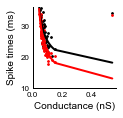

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_161220_c2_EI_0.045_spikes.pkl
Parameters([('c', <Parameter 'c', 10.0, bounds=[-inf:inf]>), ('k', <Parameter 'k', 1.0, bounds=[-inf:inf]>)])
[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 124
    # variables        = 2
    chi-square         = 380.069
    reduced chi-square = 3.115
    Akaike info crit   = 142.889
    Bayesian info crit = 148.529
[[Variables]]
    c:   5.62462593 (init= 10)
    k:   1.45441025 (init= 1)

[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 136
    # variables        = 2
    chi-square         = 233.272
    reduced chi-square = 1.741
    Akaike info crit   = 77.379
    Bayesian info crit = 83.204
[[Variables]]
    c:   5.96345377 (init= 10)
    k:   1.27073249 (init= 1)



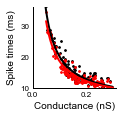

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170720_c5_EI_0.045_spikes.pkl
Parameters([('c', <Parameter 'c', 10.0, bounds=[-inf:inf]>), ('k', <Parameter 'k', 1.0, bounds=[-inf:inf]>)])
[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 34
    # data points      = 109
    # variables        = 2
    chi-square         = 668.336
    reduced chi-square = 6.246
    Akaike info crit   = 201.665
    Bayesian info crit = 207.048
[[Variables]]
    c:   10.0749499 (init= 10)
    k:   1.38284928 (init= 1)

[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 124
    # variables        = 2
    chi-square         = 251.062
    reduced chi-square = 2.058
    Akaike info crit   = 91.472
    Bayesian info crit = 97.112
[[Variables]]
    c:   9.81013075 (init= 10)
    k:   1.09050083 (init= 1)



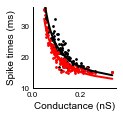

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170531_c4_EI_0.045_spikes.pkl
Parameters([('c', <Parameter 'c', 10.0, bounds=[-inf:inf]>), ('k', <Parameter 'k', 1.0, bounds=[-inf:inf]>)])
[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 45
    # variables        = 2
    chi-square         = 264.787
    reduced chi-square = 6.158
    Akaike info crit   = 83.752
    Bayesian info crit = 87.365
[[Variables]]
    c:   10.0868242 (init= 10)
    k:   1.11444063 (init= 1)

[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 48
    # variables        = 2
    chi-square         = 220.444
    reduced chi-square = 4.792
    Akaike info crit   = 77.173
    Bayesian info crit = 80.916
[[Variables]]
    c:   9.85913090 (init= 10)
    k:   1.06020530 (init= 1)



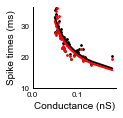

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170720_c2_EI_0.045_spikes.pkl
Parameters([('c', <Parameter 'c', 10.0, bounds=[-inf:inf]>), ('k', <Parameter 'k', 1.0, bounds=[-inf:inf]>)])
[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 139
    # variables        = 2
    chi-square         = 355.797
    reduced chi-square = 2.597
    Akaike info crit   = 134.644
    Bayesian info crit = 140.513
[[Variables]]
    c:   5.23648979 (init= 10)
    k:   1.88092084 (init= 1)

[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 180
    # variables        = 2
    chi-square         = 336.029
    reduced chi-square = 1.888
    Akaike info crit   = 116.363
    Bayesian info crit = 122.749
[[Variables]]
    c:   8.06267750 (init= 10)
    k:   0.95137150 (init= 1)



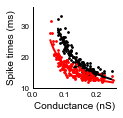

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170510_c2_EI_0.045_spikes.pkl
Parameters([('c', <Parameter 'c', 10.0, bounds=[-inf:inf]>), ('k', <Parameter 'k', 1.0, bounds=[-inf:inf]>)])
[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 34
    # data points      = 23
    # variables        = 2
    chi-square         = 258.172
    reduced chi-square = 12.294
    Akaike info crit   = 59.617
    Bayesian info crit = 61.888
[[Variables]]
    c:   7.01026503 (init= 10)
    k:   1.95154522 (init= 1)

[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 46
    # data points      = 90
    # variables        = 2
    chi-square         = 428.372
    reduced chi-square = 4.868
    Akaike info crit   = 144.416
    Bayesian info crit = 149.416
[[Variables]]
    c:   5.47132986 (init= 10)
    k:   1.21741944 (init= 1)



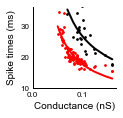

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170720_c3_EI_0.045_spikes.pkl
Parameters([('c', <Parameter 'c', 10.0, bounds=[-inf:inf]>), ('k', <Parameter 'k', 1.0, bounds=[-inf:inf]>)])
[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 129
    # variables        = 2
    chi-square         = 472.042
    reduced chi-square = 3.717
    Akaike info crit   = 171.346
    Bayesian info crit = 177.066
[[Variables]]
    c:   10.1312091 (init= 10)
    k:   1.22735612 (init= 1)

[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 144
    # variables        = 2
    chi-square         = 282.651
    reduced chi-square = 1.990
    Akaike info crit   = 101.113
    Bayesian info crit = 107.053
[[Variables]]
    c:   7.27126284 (init= 10)
    k:   1.47570266 (init= 1)



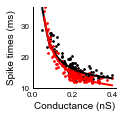

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170524_c3_EI_0.045_spikes.pkl
Parameters([('c', <Parameter 'c', 10.0, bounds=[-inf:inf]>), ('k', <Parameter 'k', 1.0, bounds=[-inf:inf]>)])
[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 34
    # data points      = 52
    # variables        = 2
    chi-square         = 339.061
    reduced chi-square = 6.781
    Akaike info crit   = 101.497
    Bayesian info crit = 105.399
[[Variables]]
    c:   10.6112038 (init= 10)
    k:   0.97718119 (init= 1)

[[Model]]
    Model(one_by_x)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 53
    # variables        = 2
    chi-square         = 169.435
    reduced chi-square = 3.322
    Akaike info crit   = 65.595
    Bayesian info crit = 69.536
[[Variables]]
    c:   9.35572538 (init= 10)
    k:   1.02206309 (init= 1)



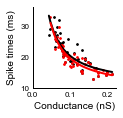

In [131]:
dn_k, gaba_k = [], []
dn_c, gaba_c = [], []
for f in glob.glob("/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_*0.045_spikes.pkl"):
    print(f)
    prefix, suffix = f.split('_spikes')
    with open (f, 'r') as g:
        sdn_x, sdn_y, sdn_y2, IE_ratio_arr, IE_pair, IE_onset= pickle.load(g)

    sdn_x, sdn_y, sdn_y2  = [convertInfToNan(j) for j in [sdn_x, sdn_y, sdn_y2]] #, IE_ratio_arr, IE_pair, IE_onset]]
    
    sdn_x, sdn_y, sdn_y2 = sdn_x.reshape((len(sdn_x)/6,6)), sdn_y.reshape((len(sdn_y)/6,6)), sdn_y2.reshape((len(sdn_y2)/6,6))
    
    sdn_x, sdn_y, sdn_y2 = np.nanmedian(sdn_x, axis=1), np.nanmedian(sdn_y, axis=1), np.nanmedian(sdn_y2, axis=1)
    
    indices = np.logical_not(np.any((np.isnan(sdn_x), np.isnan(sdn_y)), axis=0))
    
    sdn_xi, sdn_y = sdn_x[indices], sdn_y[indices]
    
    fig, ax = plt.subplots()
    ax.scatter(sdn_xi, sdn_y, marker='.', c='k', s=12)    

    X = np.copy(sdn_xi)
    y = np.copy(sdn_y) #Control
    y2 = np.copy(sdn_y2) #GABAzine

    idx   = np.argsort(X)
    X = X[idx]
    y = y[idx]
    
    method = 'L-BFGS-B'
    DN_Model = lmfit.Model(one_by_x)
    DN_pars = DN_Model.make_params()
    print(DN_pars)
    DN_result = DN_Model.fit(y, DN_pars, x=X, method=method, reduce_fcn='neglogcauchy')
    
#     dn_aic.append(DN_result.aic)
#     dn_chi.append(DN_result.redchi)

    print (DN_result.fit_report())

#     ax.set_xlim(xmin=0.)
#     ax.set_ylim(ymin=0.)
#     ax.set_xlabel("Expected")
#     ax.set_ylabel("Observed")
    ax.set_title("Divisive Normalization fits")
    
    div_norm = ax.plot(X, DN_result.best_fit, '-', color='k', lw=2)
    
    
    indices = np.logical_not(np.any((np.isnan(sdn_x), np.isnan(sdn_y2)), axis=0))
    sdn_xj, sdn_y2 = sdn_x[indices], sdn_y2[indices]
    
    X = np.copy(sdn_xj)
    y2 = np.copy(sdn_y2) #GABAzine
    
    idx   = np.argsort(X)
    X = X[idx]
    y2 = y2[idx]
    
    ax.scatter(sdn_xj, sdn_y2, marker='.', c='r', s=12)
    
    
    #     div_inh = ax.plot(X, lin_result.best_fit, '-', color='green', lw=2)

    dn_k.append(DN_result.params["k"])
    dn_c.append(DN_result.params["c"])
    
    DN_Model2 = lmfit.Model(one_by_x)
    DN_pars = DN_Model2.make_params()
    
    DN_result2 = DN_Model2.fit(y2, DN_pars, x=X, method=method, reduce_fcn='neglogcauchy')
    print (DN_result2.fit_report())
    div_norm_GABAzine = ax.plot(X, DN_result2.best_fit, '-', color='r', lw=2)
    gaba_k.append(DN_result2.params["k"])
    gaba_c.append(DN_result2.params["c"])
    
    
    ax.set_xlabel("Conductance (nS)")
    ax.set_ylabel("Spike times (ms)")
    ax.set_xlim(xmin=0.)
    ax.set_ylim(ymin=10., ymax=36)

    
    simpleaxis(ax)
    fig.set_figwidth(1.5)
    fig.set_figheight(1.5)
    
    plt.savefig(prefix + "_NaturalThreshold.svg", transparent=True, bbox_inches='tight')
    plt.show(fig)
    plt.close()

RanksumsResult(statistic=2.0256410256410255, pvalue=0.04280158418044451)
N is 13
1.360910385420767 1.1319170094283557


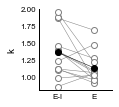

RanksumsResult(statistic=0.6410256410256411, pvalue=0.5215060239121667)


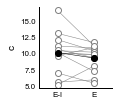

In [141]:
prefix = "/media/sahil/NCBS_Shares_BGStim/Paper/Submissions/Elife/Figures/"
print(ss.ranksums(dn_k,gaba_k))
print ("N is {}".format(len(dn_k)))
print(np.mean(dn_k), np.mean(gaba_k))
indices = [1,2]

fig, ax = plt.subplots()
for ind, (l,d) in enumerate(zip(gaba_k, dn_k)):
    ax.plot(indices, [d,l], 'o-', alpha=1, color='0.5', markerfacecolor='white',markersize=6)
ax.plot(indices, [np.average(dn_k), np.average(gaba_k)],'o-', alpha=1., color='0',markersize=6)
ax.set_xlim((0.5,2.5))
# ax.set_ylim(ymin=-4,ymax=70)
ax.set_ylabel("k")
ax.set_xticks(indices)
ax.set_xticklabels(('E-I','E'))
y, h, col = np.max([np.max(gaba_k),np.max(dn_k)])+ 8 , 2, 'k'
# plt.plot([1,1, 2, 2], [y, y+h, y+h, y], lw=1.5, c=col)
# plt.text((1+2)*.5, y+h, "*", ha='center', va='bottom', color=col)

simpleaxis(ax)
fig.set_figwidth(1.3)
fig.set_figheight(1.5)
plt.savefig(prefix + "summaryFig_one_by_x_k.svg", transparent=True, bbox_inches='tight')
plt.show()

print(ss.ranksums(dn_c,gaba_c))
fig, ax = plt.subplots()
for ind, (l,d) in enumerate(zip(gaba_c, dn_c)):
    ax.plot(indices, [d,l], 'o-', alpha=1, color='0.5', markerfacecolor='white',markersize=6)
ax.plot(indices, [np.average(dn_c), np.average(gaba_c)],'o-', alpha=1., color='0',markersize=6)
ax.set_xlim((0.5,2.5))
# ax.set_ylim(ymin=-4,ymax=70)
ax.set_ylabel("c")
ax.set_xticks(indices)
ax.set_xticklabels(('E-I','E'))
y, h, col = np.max([np.max(gaba_c),np.max(dn_c)])+ 8 , 2, 'k'
# plt.plot([1,1, 2, 2], [y, y+h, y+h, y], lw=1.5, c=col)
# plt.text((1+2)*.5, y+h, "*", ha='center', va='bottom', color=col)

simpleaxis(ax)
fig.set_figwidth(1.3)
fig.set_figheight(1.5)
plt.savefig(prefix + "summaryFig_one_by_x_c.svg", transparent=True, bbox_inches='tight')
plt.show()

## No spiking case

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170720_c2_EI_nospikes.pkl
100
[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 27
    # data points      = 180
    # variables        = 1
    chi-square         = 126.776
    reduced chi-square = 0.708
    Akaike info crit   = -61.097
    Bayesian info crit = -57.904
[[Variables]]
    gamma:   21.5811118 (init= 1)

[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 75
    # data points      = 180
    # variables        = 1
    chi-square         = 297.828
    reduced chi-square = 1.664
    Akaike info crit   = 92.641
    Bayesian info crit = 95.834
[[Variables]]
    gamma:   88446.0178 (init= 1)



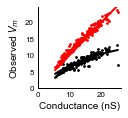

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170510_c2_EI_nospikes.pkl
100
[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 150
    # variables        = 1
    chi-square         = 131.522
    reduced chi-square = 0.883
    Akaike info crit   = -17.719
    Bayesian info crit = -14.708
[[Variables]]
    gamma:   12.4819895 (init= 1)

[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 71
    # data points      = 150
    # variables        = 1
    chi-square         = 111.065
    reduced chi-square = 0.745
    Akaike info crit   = -43.078
    Bayesian info crit = -40.068
[[Variables]]
    gamma:   45792.9732 (init= 1)



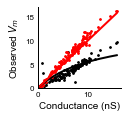

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170531_c2_EI_nospikes.pkl
100
[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 120
    # variables        = 1
    chi-square         = 300.885
    reduced chi-square = 2.528
    Akaike info crit   = 112.308
    Bayesian info crit = 115.096
[[Variables]]
    gamma:   42.3671503 (init= 1)

[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 47
    # data points      = 120
    # variables        = 1
    chi-square         = 122.313
    reduced chi-square = 1.028
    Akaike info crit   = 4.291
    Bayesian info crit = 7.078
[[Variables]]
    gamma:   317.780055 (init= 1)



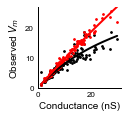

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_161220_c2_EI_nospikes.pkl
100
[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 29
    # data points      = 150
    # variables        = 1
    chi-square         = 258.105
    reduced chi-square = 1.732
    Akaike info crit   = 83.410
    Bayesian info crit = 86.420
[[Variables]]
    gamma:   36.5493808 (init= 1)

[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 59
    # data points      = 150
    # variables        = 1
    chi-square         = 315.582
    reduced chi-square = 2.118
    Akaike info crit   = 113.568
    Bayesian info crit = 116.578
[[Variables]]
    gamma:   1465.23714 (init= 1)



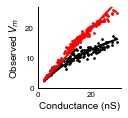

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170531_c1_EI_nospikes.pkl
100
[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 19
    # data points      = 180
    # variables        = 1
    chi-square         = 1586.037
    reduced chi-square = 8.861
    Akaike info crit   = 393.687
    Bayesian info crit = 396.880
[[Variables]]
    gamma:   20.6704365 (init= 1)

[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 29
    # data points      = 180
    # variables        = 1
    chi-square         = 355.120
    reduced chi-square = 1.984
    Akaike info crit   = 124.310
    Bayesian info crit = 127.503
[[Variables]]
    gamma:   99.3883951 (init= 1)



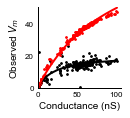

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170530_c2_EI_nospikes.pkl
100
[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 31
    # data points      = 180
    # variables        = 1
    chi-square         = 352.750
    reduced chi-square = 1.971
    Akaike info crit   = 123.105
    Bayesian info crit = 126.298
[[Variables]]
    gamma:   34.6149131 (init= 1)

[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 71
    # data points      = 180
    # variables        = 1
    chi-square         = 333.391
    reduced chi-square = 1.863
    Akaike info crit   = 112.945
    Bayesian info crit = 116.138
[[Variables]]
    gamma:   71627.7438 (init= 1)



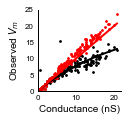

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170720_c3_EI_nospikes.pkl
100
[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 25
    # data points      = 150
    # variables        = 1
    chi-square         = 336.094
    reduced chi-square = 2.256
    Akaike info crit   = 123.013
    Bayesian info crit = 126.024
[[Variables]]
    gamma:   21.2791576 (init= 1)

[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 41
    # data points      = 150
    # variables        = 1
    chi-square         = 287.168
    reduced chi-square = 1.927
    Akaike info crit   = 99.415
    Bayesian info crit = 102.425
[[Variables]]
    gamma:   221.115230 (init= 1)



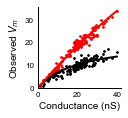

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170720_c4_EI_nospikes.pkl
100
[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 27
    # data points      = 60
    # variables        = 1
    chi-square         = 67.843
    reduced chi-square = 1.150
    Akaike info crit   = 9.371
    Bayesian info crit = 11.465
[[Variables]]
    gamma:   31.4314913 (init= 1)

[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 45
    # data points      = 60
    # variables        = 1
    chi-square         = 129.727
    reduced chi-square = 2.199
    Akaike info crit   = 48.265
    Bayesian info crit = 50.360
[[Variables]]
    gamma:   384.796766 (init= 1)



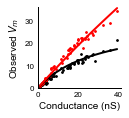

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170524_c3_EI_nospikes.pkl
100
[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 37
    # data points      = 90
    # variables        = 1
    chi-square         = 255.270
    reduced chi-square = 2.868
    Akaike info crit   = 95.826
    Bayesian info crit = 98.326
[[Variables]]
    gamma:   83.1895430 (init= 1)

[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 67
    # data points      = 90
    # variables        = 1
    chi-square         = 150.233
    reduced chi-square = 1.688
    Akaike info crit   = 48.114
    Bayesian info crit = 50.614
[[Variables]]
    gamma:   36012.4526 (init= 1)



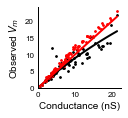

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170531_c4_EI_nospikes.pkl
100
[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 43
    # data points      = 90
    # variables        = 1
    chi-square         = 90.325
    reduced chi-square = 1.015
    Akaike info crit   = 2.325
    Bayesian info crit = 4.824
[[Variables]]
    gamma:   120.182079 (init= 1)

[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 69
    # data points      = 90
    # variables        = 1
    chi-square         = 117.028
    reduced chi-square = 1.315
    Akaike info crit   = 25.634
    Bayesian info crit = 28.134
[[Variables]]
    gamma:   36957.1911 (init= 1)



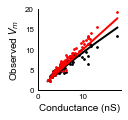

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170524_c1_EI_nospikes.pkl
100
[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 27
    # data points      = 120
    # variables        = 1
    chi-square         = 187.107
    reduced chi-square = 1.572
    Akaike info crit   = 55.303
    Bayesian info crit = 58.090
[[Variables]]
    gamma:   19.6309403 (init= 1)

[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 33
    # data points      = 120
    # variables        = 1
    chi-square         = 803.887
    reduced chi-square = 6.755
    Akaike info crit   = 230.236
    Bayesian info crit = 233.024
[[Variables]]
    gamma:   60.9914314 (init= 1)



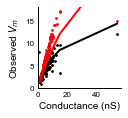

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170530_c1_EI_nospikes.pkl
100
[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 23
    # data points      = 150
    # variables        = 1
    chi-square         = 313.116
    reduced chi-square = 2.101
    Akaike info crit   = 112.391
    Bayesian info crit = 115.401
[[Variables]]
    gamma:   17.5752440 (init= 1)

[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 43
    # data points      = 150
    # variables        = 1
    chi-square         = 609.996
    reduced chi-square = 4.094
    Akaike info crit   = 212.422
    Bayesian info crit = 215.433
[[Variables]]
    gamma:   312.314534 (init= 1)



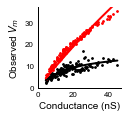

/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_170720_c5_EI_nospikes.pkl
100
[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 27
    # data points      = 150
    # variables        = 1
    chi-square         = 220.879
    reduced chi-square = 1.482
    Akaike info crit   = 60.047
    Bayesian info crit = 63.057
[[Variables]]
    gamma:   23.2194182 (init= 1)

[[Model]]
    Model(DN_model)
[[Fit Statistics]]
    # function evals   = 73
    # data points      = 150
    # variables        = 1
    chi-square         = 545.132
    reduced chi-square = 3.659
    Akaike info crit   = 195.559
    Bayesian info crit = 198.570
[[Variables]]
    gamma:   1.0367e+05 (init= 1)



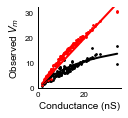

In [142]:
dn_aic, dn_chi = [], []
dn_gamma, gaba_gamma = [], []
for f in glob.glob("/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_*_nospikes.pkl"):
    print(f)
    prefix, suffix = f.split('_nospikes')
    with open (f, 'r') as g:
        sdn_x, sdn_y, sdn_y2, IE_ratio_arr, IE_pair, IE_onset= pickle.load(g)
        
    sdn_x, sdn_y, sdn_y2  = [convertInfToNan(j) for j in [sdn_x, sdn_y, sdn_y2]] #, IE_ratio_arr, IE_pair, IE_onset]]
    sdn_x, sdn_y, sdn_y2 = sdn_x.reshape((len(sdn_x)/6,6)), sdn_y.reshape((len(sdn_y)/6,6)), sdn_y2.reshape((len(sdn_y2)/6,6))
    sdn_x, sdn_y, sdn_y2 = np.nanmedian(sdn_x, axis=1), np.nanmedian(sdn_y, axis=1), np.nanmedian(sdn_y2, axis=1)
    
   
    Vmax = max(y2)
    gmax = max(sdn_y2)
    
#     factor = float(Vmax)/gmax
    factor = 100
    print(factor)
    
    X = np.copy(sdn_y2) *factor
    y = np.copy(sdn_y) #Control
    y2 = np.copy(sdn_x) #GABAzine
    
    
    fig, ax = plt.subplots()
    ax.scatter(X, y, marker='.', c='k', s=12)
    ax.scatter(X, y2,  marker='.', c='r', s=12)
    ax.set_xlabel("Conductance (nS)")
    ax.set_ylabel("Observed $V_m$")
    ax.set_xlim(xmin=0.)
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin=0.)#, ymax= 1.5*ymax)

    method = 'L-BFGS-B'
    idx   = np.argsort(X)
    X = X[idx]
    y = y[idx]
    y2 = y2[idx]
        
    DN_Model = lmfit.Model(DN_model)
    DN_pars = DN_Model.make_params()
    DN_result = DN_Model.fit(y, DN_pars, x=X, method=method, reduce_fcn='neglogcauchy')
    
    dn_aic.append(DN_result.aic)
    dn_chi.append(DN_result.redchi)

    print (DN_result.fit_report())

#     ax.set_xlim(xmin=0.)
#     ax.set_ylim(ymin=0.)
#     ax.set_xlabel("Expected")
#     ax.set_ylabel("Observed")
    ax.set_title("Divisive Normalization fits")
#     div_inh = ax.plot(X, lin_result.best_fit, '-', color='green', lw=2)
    div_norm = ax.plot(X, DN_result.best_fit, '-', color='k', lw=2)
    dn_gamma.append(DN_result.params["gamma"])
    
    DN_Model2 = lmfit.Model(DN_model)
    DN_pars = DN_Model2.make_params()
    
    DN_result2 = DN_Model2.fit(y2, DN_pars, x=X, method=method, reduce_fcn='neglogcauchy')
    print (DN_result2.fit_report())
    div_norm_GABAzine = ax.plot(X, DN_result2.best_fit, '-', color='r', lw=2)
    gaba_gamma.append(DN_result2.params["gamma"])
    
#     max_exp *=1.1
#     max_g_exp *=1.1
    
#     ax.set_xlim(0,max_exp)

#     ax.set_ylim(0,max_exp)

#     linear = ax.plot((0,max_exp), (0,max_exp), 'k--')

#     legends =  div_norm
    # labels = ["Divisive Inhibition, $\\beta$ = {:.2f}".format(lin_result.params['beta'].value), "Divisive Normalization, $\\beta$ = {:.2f}, $\\gamma$ = {:.2f}".format(DN_result.params['beta'].value, DN_result.params['gamma'].value), "Linear sum"] +  sorted(observed.keys()) 
#     labels = ["Divisive Inhibition, $\\beta$ = {:.2f}".format(lin_result.params['beta'].value), "Divisive Normalization, $\\gamma$ = {:.2f}".format(DN_result.params['gamma'].value), "Linear sum"] +  sorted(observed.keys()) 

#     ax.legend(legends, labels, loc='upper left')

    simpleaxis(ax)
    fig.set_figwidth(1.5)
    fig.set_figheight(1.5)
#     dump(fig,file('figures/fig4/4b.pkl','wb'))

    
#     simpleaxis(ax)
#     fig.set_figwidth(1.3)
#     fig.set_figheight(1.3)

    plt.savefig(prefix + "_subthreshold.svg", transparent=True, bbox_inches='tight')
    plt.show()
#     plt.show(fig)
#     plt.close()

RanksumsResult(statistic=-4.17948717948718, pvalue=2.921671892184398e-05)
N is 13


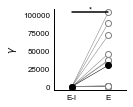

In [140]:
prefix = "/media/sahil/NCBS_Shares_BGStim/Paper/Submissions/Elife/Figures/"
print(ss.ranksums(dn_gamma,gaba_gamma))
print ("N is {}".format(len(dn_gamma)))

indices = [1,2]
fig, ax = plt.subplots()
for ind, (l,d) in enumerate(zip(gaba_gamma, dn_gamma)):
    ax.plot(indices, [d,l], 'o-', alpha=1, color='0.5', markerfacecolor='white',markersize=6)
ax.plot(indices, [np.average(dn_gamma), np.average(gaba_gamma)],'o-', alpha=1., color='0',markersize=6)
ax.set_xlim((0.5,2.5))
# ax.set_ylim(ymin=-4,ymax=70)
ax.set_ylabel("$\\gamma$")
ax.set_xticks(indices)
ax.set_xticklabels(('E-I','E'))
y, h, col = np.max([np.max(gaba_gamma),np.max(dn_gamma)])+ 8 , 2, 'k'
plt.plot([1,1, 2, 2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((1+2)*.5, y+h, "*", ha='center', va='bottom', color=col)

simpleaxis(ax)
fig.set_figwidth(1.3)
fig.set_figheight(1.5)
plt.savefig(prefix + 'summaryFig_gamma_subthreshold_voltageClamp.svg')
plt.show()

In [120]:
print(prefix + 'summaryFig_gamma_subthreshold_voltageClamp.svg')

/media/sahil/NCBS_Shares_BGStim/Paper/Submissions/Elife/Figures/summaryFig_gamma_subthreshold_voltageClamp.svg


In [ ]:
# import scipy.stats as ss
thresArr = [-0.0575, -0.055, -0.0525]
for f in glob.glob("/home/bhalla/Documents/Codes/linearity/DN_widget/SDN/sdn_*-0.055_spikes.pkl"):
    # Getting the IQR
    filename = f.split("-")[0] + "nospikes.pkl"
    print(filename)
    #sdn_x, sdn_y, sdn_y2, IE_ratio_arr = getSDNPlotVals(filename)
    with open (filename, 'r') as g:
        sdn_x, sdn_y, sdn_y2, IE_ratio_arr, IE_pair, IE_onset= pickle.load(g)
    sdn_x, sdn_y, sdn_y2, IE_ratio_arr, IE_pair, IE_onset = [np.array(j) for j in [sdn_x, sdn_y, sdn_y2, IE_ratio_arr, IE_pair, IE_onset]]
    
#     bins = np.linspace(0,1,31)
#     fig, ax = plt.subplots()
#     ax.hist((sdn_x-sdn_y)/sdn_x, bins=bins)
#     plt.show()
    
#     bins = np.linspace(0,30,61)
#     indices = np.digitize(sdn_x, bins)
    
#     indices1, sdn_x1, sdn_y1 = zip(*sorted(zip(indices, sdn_x, sdn_y)))
    
    
    
#     fig, ax = plt.subplots()
#     ax.scatter(sdn_x, (sdn_x-sdn_y)/sdn_x)
#     ax.set_xlim(xmin=0.)
#     ax.set_ylim(ymin=0.)
#     plt.show()
    
    fig, ax = plt.subplots(nrows=len(thresArr), sharex=True, sharey=True)
    for j in range(len(thresArr)):
        filename = f.split("-")[0] + str(thresArr[j]) + "_spikes.pkl"
        sdn_x, sdn_y, sdn_y2, IE_ratio_arr = getSDNPlotVals(filename)
        deltaSpikeTime = sdn_y-sdn_y2
        bins = np.linspace(-1,10,100)
        n, bins, patches = ax[j].hist(deltaSpikeTime, bins=bins, color='k')
        ax[j].vlines(x=np.median(deltaSpikeTime), ymin=0, ymax=max(n)*1.1, linestyles='--', color='0.2')
        ax[j].vlines(x=0., ymin=0, ymax=max(n)*1.1, linestyles='--', color='r')
        simpleaxis(ax[j])
        ax[j].set_title(str(thresArr[j]) + "mV")
    
    fig.set_figwidth(6)
    fig.set_figheight(6)
    plt.show(fig)